In [1]:
import pandas as pd
import pandas

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import cv2
import sys
import argparse

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, Function
from torchvision import datasets, models, transforms, utils
import torchvision
import torch.nn.functional as F
import torch.nn as nn

In [2]:
image_data_transforms = {
    'training': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [3]:
import zipfile

zip_path = "/Flower_Classification.zip"
destination_dir = "/content/dataset"

!mkdir -p {destination_dir}

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


In [4]:
def load_data(batch_size, input_size = (224, 224 ,3),image_data_transforms=None):
    training_path = '/content/dataset/Flower Classification/Flower Classification/Training Data'
    validation_path = '/content/dataset/Flower Classification/Flower Classification/Validation Data'
    testing_path = '/content/dataset/Flower Classification/Flower Classification/Testing Data'

    train_data = torchvision.datasets.ImageFolder(training_path, transform=image_data_transforms['training'])
    validation_data = torchvision.datasets.ImageFolder(validation_path, transform=image_data_transforms['validation'])
    test_data = torchvision.datasets.ImageFolder(testing_path, transform=image_data_transforms['testing'])

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, validation_loader


In [5]:
#DenseNet

import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights

class CNN(nn.Module):
    def __init__(self,inputDims) -> None:
        super(CNN , self).__init__()

        self.pretrained = models.densenet121(weights=None)

        self.fc_layer = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.1),

                    nn.Linear(512, 256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.1),

                    nn.Linear(256, 128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.1),

                    nn.Linear(128, 11)
                )

        self.pretrained.classifier = self.fc_layer
        self.features = {}
        self.pretrained.classifier.register_forward_pre_hook(self.get_features("embeddings"))

    def get_features(self,name):
        def hook(model, input):
            self.features[name] = input[0].detach().cpu().numpy()
        return hook

    def forward(self, x):
          x = self.pretrained(x)
          return x

model2 = CNN((224,224))
print(model2)


CNN(
  (pretrained): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm


def visualize(model , data_loader):
  class2idx = {'Daisy': 0, 'Lavender': 1, 'Lily': 2, 'Rose': 3,'Sunflower': 4}
  idx2class = { value : key for key,value in  class2idx.items() }

  embeddings = np.array([])
  labels = np.array([])
  model.eval()

  out_features = 1024
  num_categories = 11

  with torch.no_grad():
    for i,data in enumerate(data_loader):
        images, labs = data[0].to(device), data[1].to(device)
        _ = model(images)

        embeds = model.features["embeddings"].reshape(-1, out_features)
        embeddings = np.append(embeddings , embeds)
        labels = np.append(labels,labs.cpu())

  model.train()

  embeddings = embeddings.reshape(-1, 1024)
  print(embeddings)
  c_labels = labels.reshape(-1 , 1).ravel()

  tsne = TSNE(n_components=2).fit_transform(embeddings)
  labels = np.array([ idx2class[ele] for ele in c_labels])

  cmap = cm.get_cmap('tab20')

  for lab in range(num_categories):
      indices = (c_labels == lab)
      plt.scatter(tsne[indices, 0],
                tsne[indices, 1],
                c=np.array(cmap(lab)).reshape(1, 4),
                label=lab,
                alpha=1)
  plt.legend(fontsize='large', markerscale=2)
  plt.show()

In [7]:
def evaluate(model , data_loader):
  model.eval()
  accuracy = 0
  with torch.no_grad():
      correct = 0
      total = 0
      for data in data_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = (correct / total) * 100

  model.train()

  return accuracy,loss.item()

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:


hyperparameters = {
  'lr' : 0.001,
  'batchsize' : 32,
  'epochs' : 30,
  'steps' : 4690,
  'decayRate' : 0.1
}

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root_path = '/content/drive/MyDrive/'

file_path = 'ai_results/'

filename = 'flower_results/'

test_model_path = 'AI/flowers/densenet/'

path = {
    'test_model_path' : root_path + test_model_path,
    'csv_file' : root_path + file_path + filename
}


Mounted at /content/drive


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model = CNN((224,224))
model.to(device)

train_loader , test_loader , val_loader = load_data(batch_size = hyperparameters["batchsize"], input_size = (224,224,3) , image_data_transforms = image_data_transforms)

print(len(train_loader))
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr= hyperparameters["lr"])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = hyperparameters['steps'], gamma=hyperparameters['decayRate'])
num_epochs = hyperparameters["epochs"]
total_steps = len(train_loader)

training_accuracy_array = np.array([])
training_loss_array =  np.array([])
validation_accuracy_array =  np.array([])
validation_loss_array =   np.array([])
num_of_epoch_array = np.array([])
max_accuracy = 0

t1 = time.time()
for epoch in range(num_epochs):
    max_accuracy = 0.0
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)

        correct = (predicted == labels).sum().item()
        if (i + 1) % 25 == 0:
            accuracy = (correct / total) * 100
            validation_accuracy , validation_loss = evaluate(model , val_loader)
            epoch_loss = loss.item()
            epoch_accuracy = accuracy
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy , validation_accuracy))

    validation_accuracy , validation_loss = evaluate(model , val_loader)
    num_of_epoch_array = np.append(num_of_epoch_array,epoch+1)
    training_accuracy_array = np.append(training_accuracy_array,epoch_accuracy)
    validation_accuracy_array = np.append(validation_accuracy_array, validation_accuracy)
    training_loss_array = np.append(training_loss_array,epoch_loss)
    validation_loss_array= np.append(validation_loss_array, validation_loss)

    if validation_accuracy > max_accuracy :
      max_accuracy = validation_accuracy
      torch.save(model.state_dict() , path["test_model_path"] + 'best_model.pt')

print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
157
Epoch [1/30], Step [25/157], Loss: 1.1533, Train Accuracy: 59.38%, Validation Accuracy: 61.92%
Epoch [1/30], Step [50/157], Loss: 0.9936, Train Accuracy: 59.38%, Validation Accuracy: 66.68%
Epoch [1/30], Step [75/157], Loss: 1.3480, Train Accuracy: 56.25%, Validation Accuracy: 69.20%
Epoch [1/30], Step [100/157], Loss: 0.7622, Train Accuracy: 78.12%, Validation Accuracy: 65.52%
Epoch [1/30], Step [125/157], Loss: 0.8831, Train Accuracy: 62.50%, Validation Accuracy: 72.04%
Epoch [1/30], Step [150/157], Loss: 0.8581, Train Accuracy: 62.50%, Validation Accuracy: 72.92%
Epoch [2/30], Step [25/157], Loss: 0.6605, Train Accuracy: 75.00%, Validation Accuracy: 68.40%
Epoch [2/30], Step [50/157], Loss: 0.7112, Train Accuracy: 78.12%, Validation Accuracy: 73.84%
Epoch [2/30], Step [75/157], Loss: 0.3651, Train Accuracy: 87.50%, Validation Accuracy: 69.76%
Epoch [2/30], Step [100/157], Loss: 0.6665, Train Accuracy: 81.25%, Validation Accuracy: 73.24%
Epoch [2/30], Step [125/157

In [14]:
import numpy as np
import pandas as pd

COLUMN_NAMES=['num_of_epochs','training_accuracy','training_loss','validation_accuracy','validation_loss']
df = pd.DataFrame(np.hstack((num_of_epoch_array[:,None],training_accuracy_array[:,None], training_loss_array[:,None], validation_accuracy_array[:,None], validation_loss_array[:,None])), columns=COLUMN_NAMES)
df.columns

val = '{:.5f}'.format(validation_loss)
final_file = path['csv_file'] + str(val)
df.to_csv(final_file + '.csv', index=False, header=True)

[[3.40064825e-03 1.31936863e-01 8.70626941e-02 ... 1.94750428e-01
  2.55912822e-02 9.38711874e-03]
 [1.43487501e+00 1.07223511e+00 1.16783157e-01 ... 5.34015894e-01
  2.99077541e-01 2.40307778e-01]
 [2.84949946e-03 2.09147006e-01 2.12082252e-01 ... 3.02231789e-01
  7.02418908e-02 3.52260508e-02]
 ...
 [3.28481704e-01 1.87490936e-02 1.30763389e-02 ... 5.77941358e-01
  3.84303421e-01 2.40631774e-01]
 [7.66429454e-02 5.46881080e-01 4.77407575e-01 ... 1.70281756e+00
  2.21051484e-01 2.71979332e-01]
 [0.00000000e+00 0.00000000e+00 2.89701187e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


<ipython-input-16-70cbddb82ae9>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


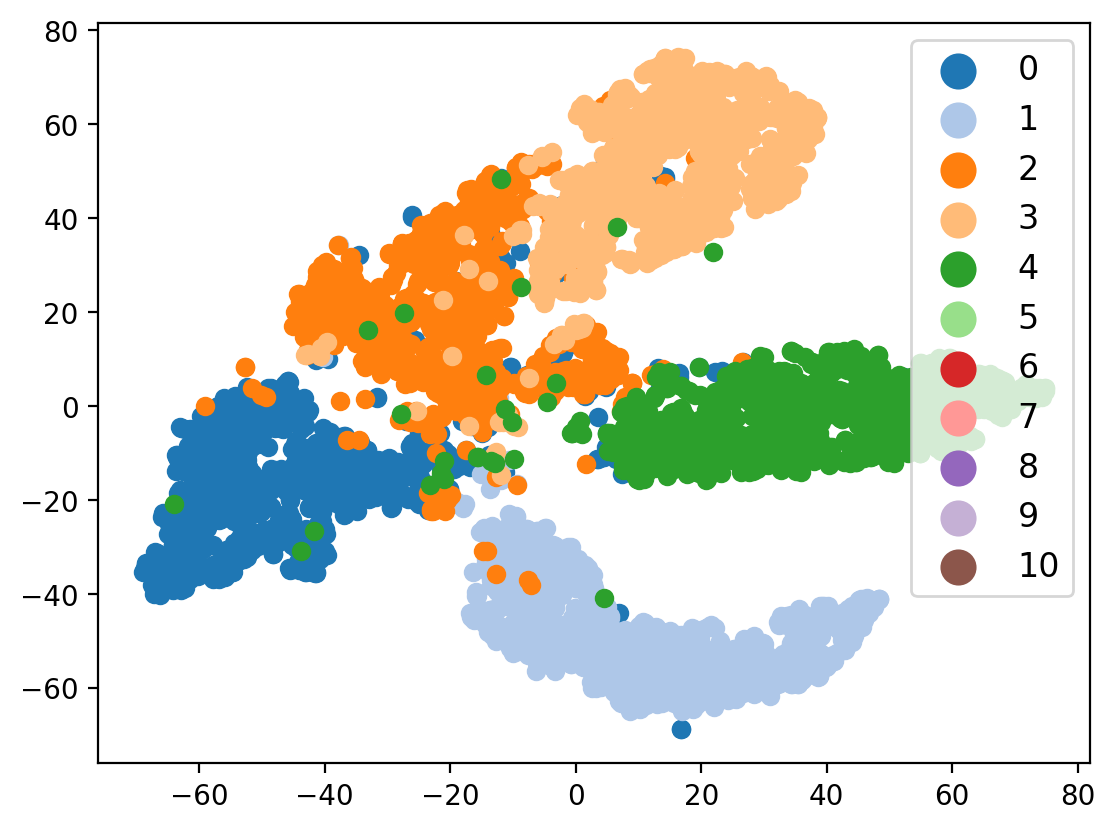

In [17]:
visualize(model , train_loader)

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive

drive.mount('/content/drive')

final_file = '/content/drive/MyDrive/ai_results/flower_results/0.01681'
dataArray = np.genfromtxt(final_file + '.csv', delimiter=',', names=True)
print(dataArray)

log_dir = '/content/drive/MyDrive/some_directory/tensorboard_logs'  # Replace with your desired log directory
writer = SummaryWriter(log_dir)

for i, epoch in enumerate(dataArray['num_of_epochs']):
    writer.add_scalars(
        'loss/train',
        {'train_loss': dataArray['training_loss'][i], 'val_loss': dataArray['validation_loss'][i]},
        epoch
    )
    writer.add_scalars(
        'accuracy/train',
        {'train_accuracy': dataArray['training_accuracy'][i], 'val_accuracy': dataArray['validation_accuracy'][i]},
        epoch
    )

writer.close()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[( 1.,  62.5  , 0.85810059, 74.2 , 0.69955939)
 ( 2.,  81.25 , 0.64436454, 74.2 , 0.45998797)
 ( 3.,  75.   , 0.70894724, 76.92, 0.5293349 )
 ( 4.,  71.875, 0.77413583, 75.36, 0.76656985)
 ( 5.,  68.75 , 0.80436003, 78.84, 0.79858303)
 ( 6.,  65.625, 0.78199542, 83.08, 0.70778131)
 ( 7.,  78.125, 0.54563373, 82.2 , 0.67777133)
 ( 8.,  75.   , 0.63258564, 84.4 , 0.51567692)
 ( 9.,  87.5  , 0.31644282, 81.36, 0.22816771)
 (10.,  96.875, 0.25589344, 83.88, 0.23729567)
 (11.,  90.625, 0.49604031, 84.12, 0.36823693)
 (12.,  87.5  , 0.37394744, 84.24, 1.37970209)
 (13.,  84.375, 0.48839092, 86.76, 0.24766561)
 (14.,  84.375, 0.40840054, 86.52, 0.54327178)
 (15.,  93.75 , 0.30670357, 87.2 , 0.17792574)
 (16.,  84.375, 0.40112391, 88.  , 0.76401716)
 (17.,  87.5  , 0.30093563, 86.96, 0.0832896 )
 (18.,  90.625, 0.36335707, 88.44, 0.11680729)
 (19.,  81.25 , 0.4033295

In [23]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))

Test Accuracy of the model on the 958 test images: 83.29853862212944 %


Test Accuracy of the model on the 958 test images: 83.29853862212944 %
tensor(0)
tensor(0)
['Daisy', 'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Daisy']
['Daisy', 'Sunflower', 'Daisy', 'Daisy', 'Daisy', 'Sunflower', 'Daisy', 'Lily', 'Daisy', 'Daisy']


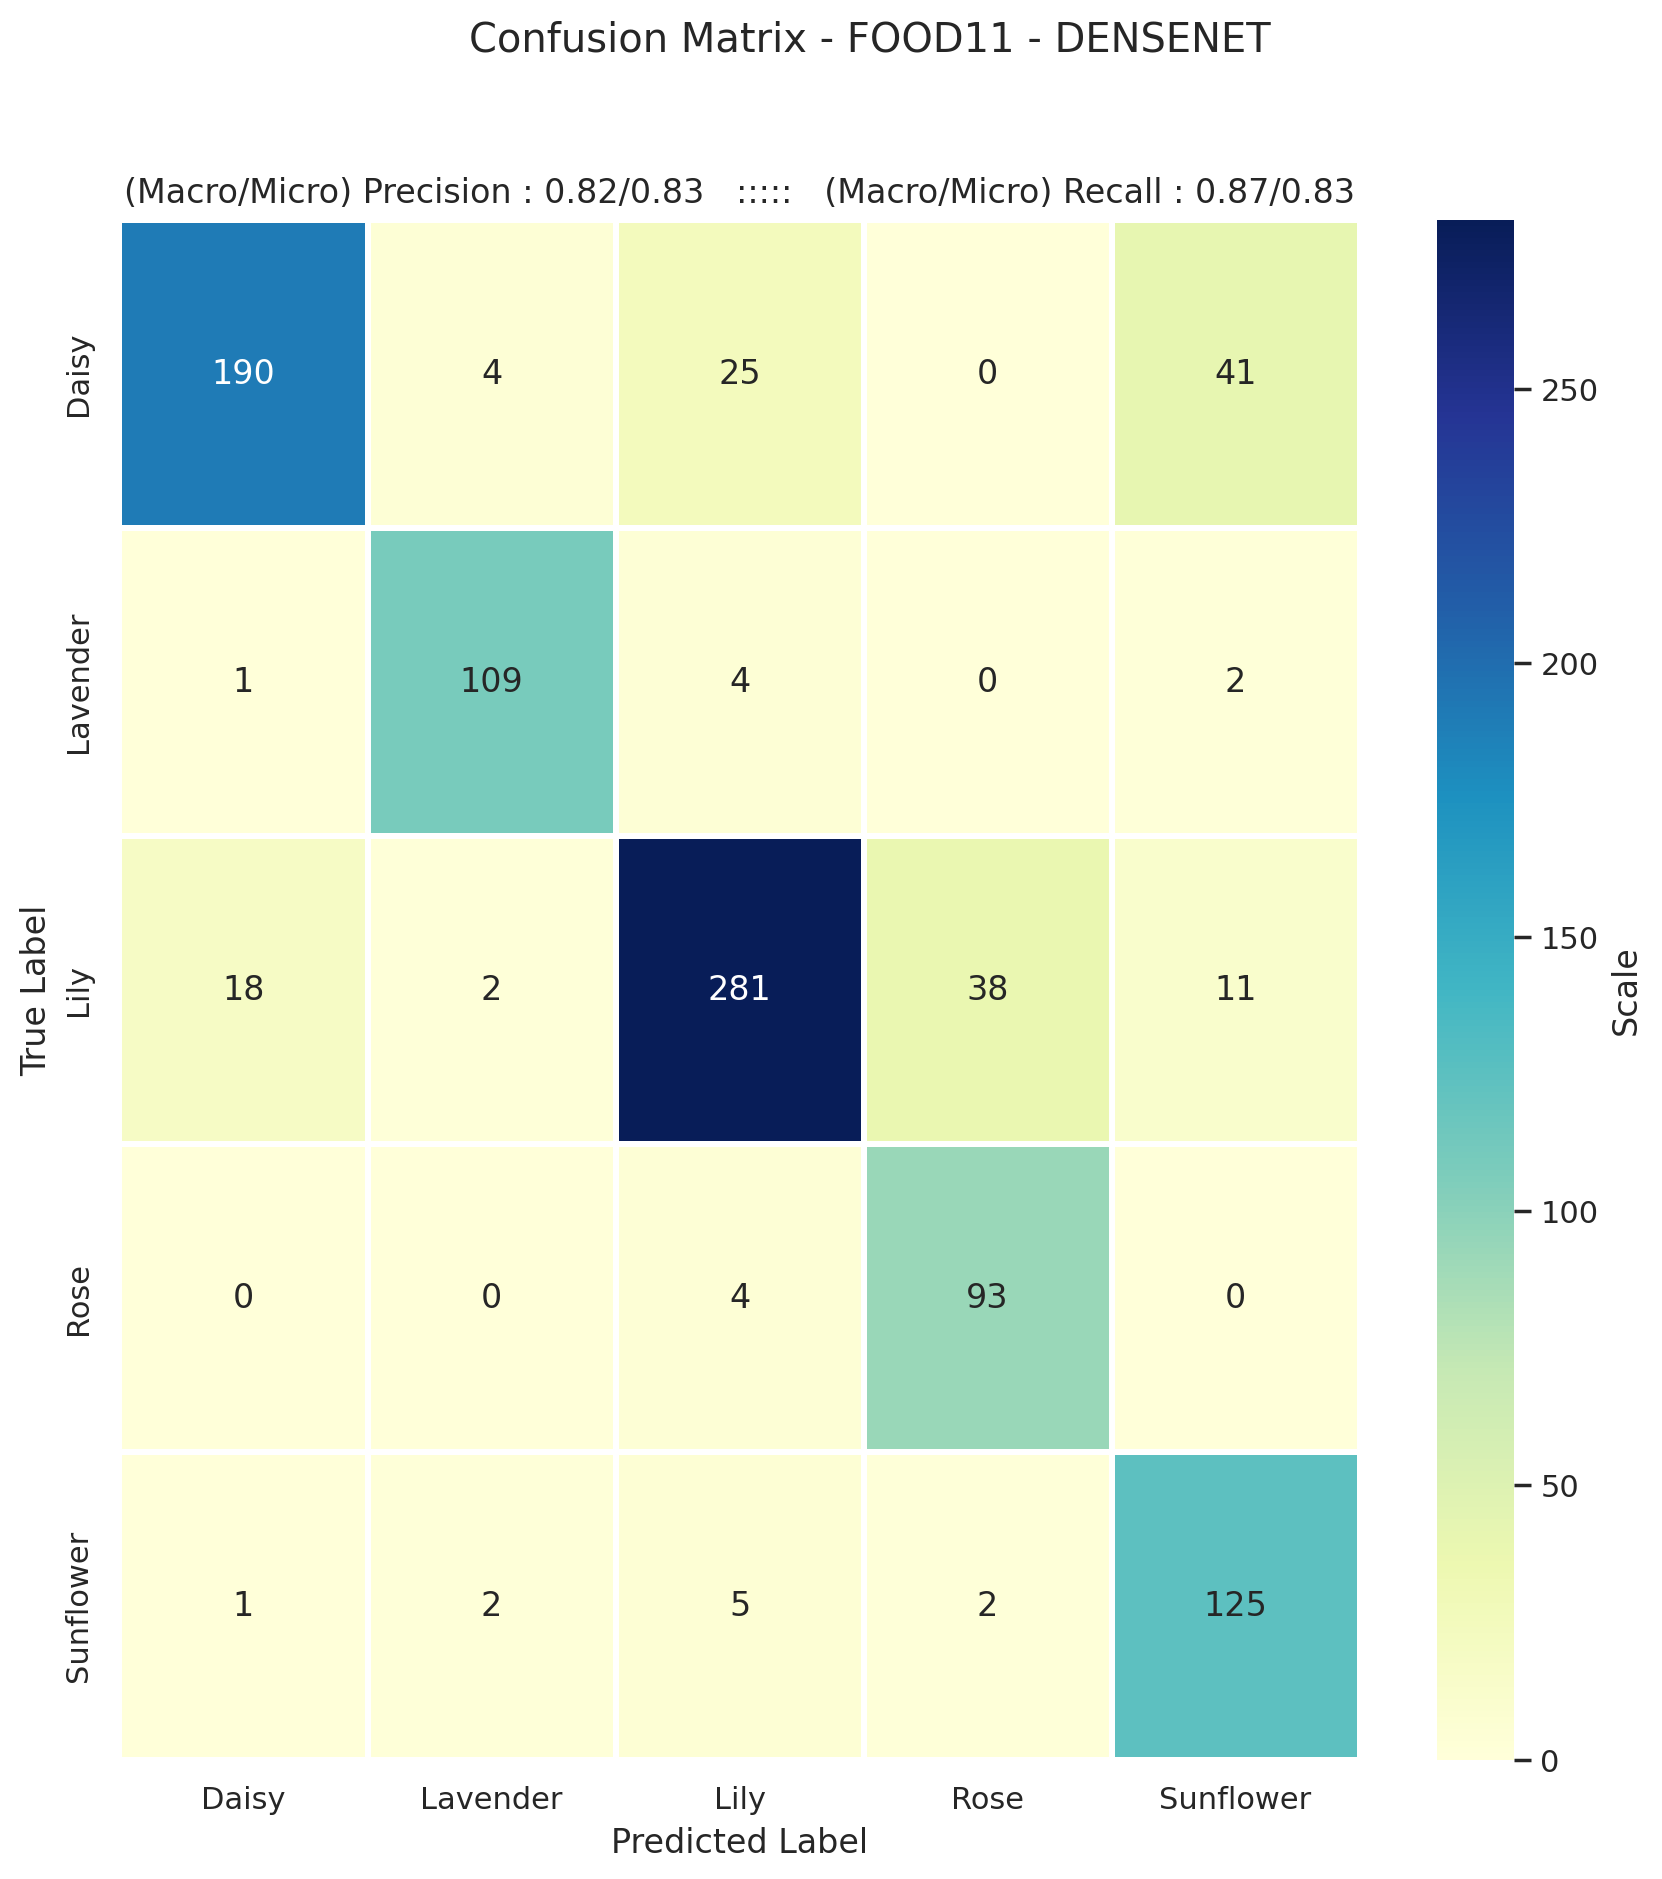

In [24]:
model.eval()

y_test = []
y_expected = []

with torch.no_grad():
    correct = 0
    total = 0


    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test.extend(predicted.to(torch.device('cpu')))
        y_expected.extend(labels.to(torch.device('cpu')))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))

print(y_test[0])

from sklearn.metrics import confusion_matrix,precision_score,recall_score
import seaborn as sns
import seaborn
import matplotlib.pyplot as plt

class2idx = {'Daisy': 0, 'Lavender': 1, 'Lily': 2, 'Rose': 3,'Sunflower': 4}
idx2class = { value : key  for key , value in class2idx.items() }

def plot_confusion_matrix(data, labels, metrics ,output_filename=None):
    """Plot confusion matrix using heatmap.

    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.

    """

    [macro_precision , micro_precision , macro_recall , micro_recall] = metrics

    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(10,10))

    plt.suptitle("Confusion Matrix - FOOD11 - DENSENET")
    plt.title(f"(Macro/Micro) Precision : {round(macro_precision,2)}/{round(micro_precision,2)}   :::::   (Macro/Micro) Recall : {round(macro_recall,2)}/{round(micro_recall,2)}")

    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu",linewidths=2 , fmt='d' ,cbar_kws={'label': 'Scale'})

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set(ylabel="True Label", xlabel="Predicted Label")

    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


print(y_expected[0])

y_true = [  idx2class[val.item()] for val in y_expected ]
y_pred = [ idx2class[val.item()] for val in y_test ]


print(y_true[:10])
print(y_pred[:10])

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
micro_precision = precision_score(y_true, y_pred, average="micro")
micro_recall = recall_score(y_true, y_pred, average="micro")


cnf_matrix = confusion_matrix(y_true , y_pred , labels=list(class2idx.keys()))

plot_confusion_matrix(cnf_matrix , class2idx.keys() , [macro_precision , micro_precision , macro_recall , micro_recall] , output_filename = "confusion_matrix.png")